# Exploring parameters

#### density plots, post predictive checks etc.

In [18]:
%load_ext autoreload
%autoreload 2
import os.path as op
import tempfile

import matplotlib.pyplot as plt


import hnn_core
from hnn_core import simulate_dipole, jones_2009_model
from hnn_core.viz import plot_dipole


import sys
sys.path.append('../code/')
sys.path.append('../code/utils/')
sys.path.append('../../results_cluster/')


import numpy as np
import torch

# visualization
import matplotlib as mpl
import matplotlib.pyplot as plt


import os

#work_dir = '/home/ubuntu/sbi_for_eeg_data/code/'

#os.chdir(work_dir)

from utils.plot import cov, compare_vars, plot_varchanges
from utils.plot import compare_KLs, plot_KLs
#import utils.sbi_modulated_functions

# sbi
from sbi import utils as utils
from sbi import analysis as analysis
from sbi.inference.base import infer
from sbi.inference import SNPE_C, prepare_for_sbi, simulate_for_sbi

from sbi.analysis import conditional_pairplot, conditional_corrcoeff



# import the summary statistics that you want to investigate
from summary_features.calculate_summary_features import calculate_summary_statistics_alternative as alternative_sumstats
from summary_features.calculate_summary_features import calculate_summary_stats_temporal as temporal_sumstats
from summary_features.calculate_summary_features import calculate_summary_stats_number as number_sumstats
from summary_features.calculate_summary_features import calculate_summary_stats_temporal


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
print(torch.__version__)

1.9.1+cu102


In [3]:
## defining neuronal network model

from utils.simulation_wrapper import event_seed, set_network_default, SimulationWrapper
sim_wrapper = SimulationWrapper(25, small_steps=True)


In [10]:
window_len = 30
prior_min = [0, 0, 0, 0, 0, 0, 0, 0, 17.3,    # prox1 weights
            0, 0, 0, 0, 0, 0, 51.980,            # distal weights
            0, 0, 0, 0, 0, 0, 0, 0, 112.13]       # prox2 weights



prior_max = [0.927, 1.0, 0.160, 1.0,  2.093, 1.0, 0.0519, 1.0, 35.9,
            0.0394, 0.117, 0.000042, 0.025902, 0.854, 0.480, 75.08, 
            0.000018, 1.0, 8.633, 1.0, 0.05375, 1.0, 4.104,  1.0, 162.110]

true_params = torch.tensor([[0.277, 0.3739, 0.0399, 0.0, 0.6244, 0.3739, 0.034, 0.0, 18.977, 
                0.011467, 0.06337, 0.000012, 0.013407, 0.466095, 0.0767, 63.08, 
                0.000005, 0.116706, 4.6729, 0.016733, 0.011468, 0.061556, 2.33, 0.0679, 120.86]])

prior = utils.torchutils.BoxUniform(low=prior_min, high=prior_max)

#number_simulations = 10
density_estimator = 'nsf'


In [6]:

#assert (prior.event_shape==torch.Size([25]))
from utils import inference

In [24]:
from utils import inference

import pickle
from data_load_writer import *
from data_load_writer import load_from_file as lf

import os

work_dir = '/home/ubuntu/sbi_for_eeg_data/'

os.chdir(work_dir)



import os

print(os.getcwd())

#os.chdir('/home/kathi/Documents/Master_thesis/results_cluster/')



#print(os.getcwd())

#os.chdir('/home/kathi/Documents/Master_thesis/results_cluster')

## loading simulations from previously saved computations
#file = 'ERP_sequential_3params/step3'
#file = 'ERP_save_sim_nsf_num_params3'
#file = 'eval_features'
file = '10000_multi_round_num_params_25newparams'

#file = '10000_sims_25_fake_obs_3steps'

os.chdir('..')
print(os.getcwd())

os.chdir('results')

print(os.getcwd())
  

thetas = torch.load('{}/thetas.pt'.format(file))

posterior = torch.load('{}/posterior.pt'.format(file))
x_without = torch.load('{}/obs_without.pt'.format(file))

x = calculate_summary_stats_temporal(x_without)


#true_params = torch.tensor([[0.0274, 19.01, 0.1369, 61.89, 0.1435, 120.86]])
#true_params = torch.tensor([[  18.9700, 63.5300, 137.1200]])
#true_params = torch.load('results/{}/true_params.pt'.format(file))
#true_params = torch.tensor([[0.277, 0.0399, 0.3739, 0.034, 18.977, 0.0115, 0.000012, 0.466, 0.06337, 0.0134, 0.0766, 63.08, 0.000005, 4.6729, 0.0115, 0.3308, 120.86]])

obs_real = torch.load('{}/obs_real.pt'.format(file))

/home/ubuntu/sbi_for_eeg_data
/home/ubuntu
/home/ubuntu/results


## Inference step:

In [11]:
density_estimator = 'nsf'



#inf = SNPE(prior=prior, density_estimator = density_estimator)

inf = SNPE_C(prior, density_estimator="nsf")

inf = inf.append_simulations(thetas, x)

density_estimator = inf.train()

posterior = inf.build_posterior(density_estimator)


#true_params = torch.tensor([[26.61, 63.53,  137.12]])

Neural network successfully converged after 58 epochs.


## Simulation under 'true parameters'

In [13]:
obs_real = inference.run_only_sim(true_params, simulation_wrapper = sim_wrapper)
#obs_real = torch.load('{}/obs_real.pt'.format(file))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
early stop 200.0
param size  25
[0.2770000100135803, 0.37389999628067017, 0.039900001138448715, 0.0, 0.6244000196456909, 0.37389999628067017, 0.03400000184774399, 0.0, 18.976999282836914, 0.011466999538242817, 0.0633699968457222, 1.2000000424450263e-05, 0.013407000340521336, 0.4660950005054474, 0.07670000195503235, 63.08000183105469, 4.999999873689376e-06, 0.1167059987783432, 4.672900199890137, 0.016733000054955482, 0.011467999778687954, 0.061556000262498856, 2.3299999237060547, 0.06790000200271606, 120.86000061035156]
set network params: [0.2770000100135803, 0.37389999628067017, 0.039900001138448715, 0.0, 0.6244000196456909, 0.37389999628067017, 0.03400000184774399, 0.0, 18.976999282836914, 0.011466999538242817, 0.0633699968457222, 1.2000000424450263e-05, 0.013407000340521336, 0.4660950005054474, 0.07670000195503235, 63.08000183105469, 4.999999873689376e-06, 0.1167059987783432, 4.672900199890137, 0.016733

In [25]:
obs_real_stat = calculate_summary_stats_temporal(obs_real)

samples = posterior.sample((100000,), x=obs_real_stat)

Drawing 100000 posterior samples:   0%|          | 0/100000 [00:00<?, ?it/s]

In [26]:
parameter_names = ["prox1_ampa_l2_bas","prox1_nmda_l2_bas","prox1_ampa_l2_pyr", "prox1_nmda_l2_pyr", "prox1_ampa_l5_bas", "prox1_nmda_l5_bas", "prox1_ampa_l5_pyr", "prox1_nmda_l5_pyr",
"t_prox1",
"dist_ampa_l2_bas", "dist_nmda_l2_bas", "dist_ampa_l2_pyr", "dist_nmda_l2_pyr", "dist_ampa_l5_pyr","dist_nmda_l5_pyr",
"t_dist", 
"prox2_ampa_l2_bas","prox2_nmda_l2_bas","prox2_ampa_l2_pyr", "prox2_nmda_l2_pyr", "prox2_ampa_l5_bas", "prox2_nmda_l5_bas", "prox2_ampa_l5_pyr", "prox2_nmda_l5_pyr",
"t_prox2"]

In [29]:
##better limits:

list_min = torch.min(samples, 0)[0]
list_max = torch.max(samples, 0)[0]

print(list_min)

print(list_max)

diff = torch.abs(list_max - list_min) * 0.5

print(diff)

list_min = list(list_min - diff)
list_max = list(list_max + diff)

limits = [list(tup) for tup in zip(list_min, list_max)]

tensor([1.6061e-05, 1.7920e-05, 1.8724e-06, 2.6329e-08, 1.7490e-03, 9.4573e-03,
        3.8486e-04, 1.6262e-05, 2.3574e+01, 1.6312e-05, 9.8165e-06, 1.1289e-08,
        5.9296e-04, 6.9444e-04, 1.4216e-03, 5.2937e+01, 6.4893e-08, 7.5802e-03,
        1.6321e-02, 3.2275e-05, 3.8324e-05, 3.1283e-03, 4.3361e-01, 2.2130e-06,
        1.1221e+02])
tensor([9.2695e-01, 9.9345e-01, 1.5967e-01, 9.6055e-02, 2.0910e+00, 7.6585e-01,
        5.1900e-02, 1.2103e-01, 2.9081e+01, 3.9398e-02, 1.1696e-01, 4.1996e-05,
        2.5869e-02, 8.5399e-01, 4.0949e-01, 6.6469e+01, 1.7999e-05, 9.9997e-01,
        8.6137e+00, 9.8859e-01, 5.3696e-02, 1.0000e+00, 4.1022e+00, 4.4941e-01,
        1.2714e+02])
tensor([4.6347e-01, 4.9671e-01, 7.9833e-02, 4.8027e-02, 1.0446e+00, 3.7819e-01,
        2.5757e-02, 6.0508e-02, 2.7531e+00, 1.9691e-02, 5.8473e-02, 2.0992e-05,
        1.2638e-02, 4.2665e-01, 2.0403e-01, 6.7659e+00, 8.9672e-06, 4.9620e-01,
        4.2987e+00, 4.9428e-01, 2.6829e-02, 4.9844e-01, 1.8343e+00, 2.2470e-01

In [31]:
#limits = [list(tup) for tup in zip(prior_min, prior_max)]


plt.set_cmap('viridis')

fig, axes = analysis.pairplot(
    samples,
    limits=limits,
    ticks=np.round(limits,2),
    figsize=(30, 30),
    points=true_params,
    points_offdiag={"markersize": 6},
    points_colors="r",
    labels=parameter_names,
)

for i in range(5):
    axes[i][i].xaxis.label.set_color('magenta')
for i in range(5, 12):
    axes[i][i].xaxis.label.set_color('navy')
for i in range(12, 17):
    axes[i][i].xaxis.label.set_color('deeppink')

KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

Error in callback <function flush_figures at 0x7fef5ca09320> (for post_execute):


KeyboardInterrupt: 

In [53]:
posterior.set_default_x(obs_real_stat)
condition = posterior.sample((1,))

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

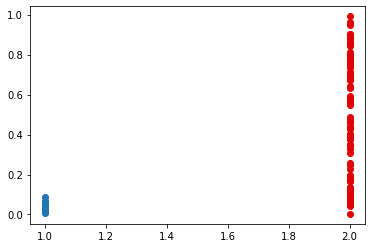

In [68]:

for i in range(100):

    plt.scatter(1, samples[i][7])
    plt.scatter(2, samples_prior[i][7])

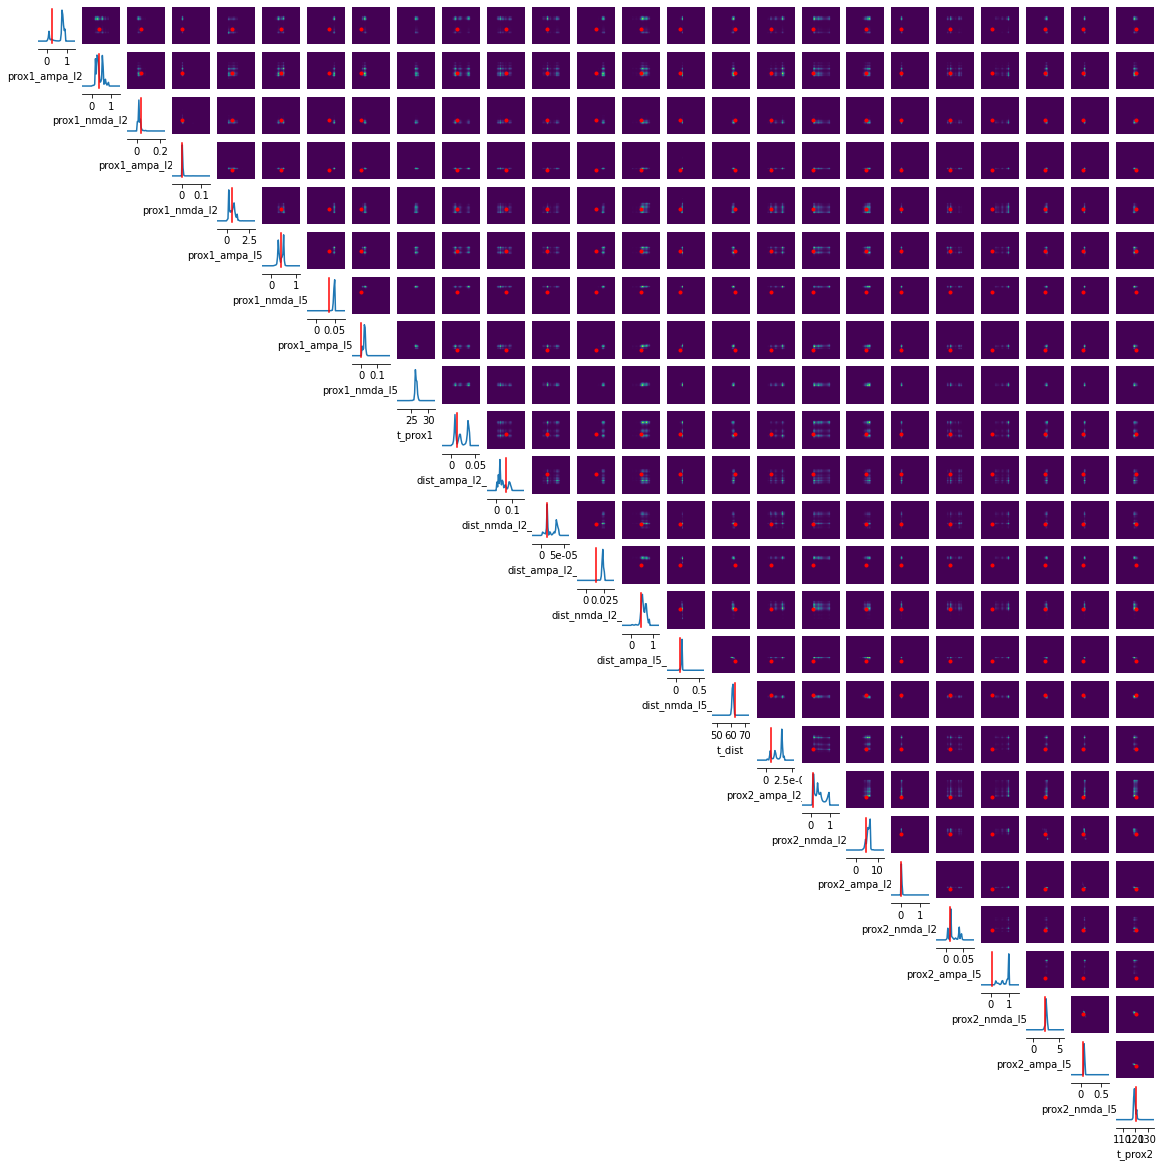

In [54]:
_ = analysis.conditional_pairplot(
    density=posterior,
    condition=condition,
    limits=limits,
    figsize=(20, 20),
    points=true_params,
    points_offdiag={"markersize": 6},
    points_colors="r",
    labels=parameter_names,
    #color_map = ['Blues', 'Reds'],
    #alpha1 = 0.8,
    #alpha2 = 0.4
 
)


In [60]:
samples = posterior.sample((100,), x=obs_real_stat)

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

In [61]:
s_x = inference.run_only_sim(samples, simulation_wrapper=sim_wrapper, num_workers=8)

early stop early stop early stop 200.0
200.0200.0param size 

 param size early stop 25 param size 
25200.0[0.7285894751548767, 0.2843892276287079, 0.006767905782908201, 0.000907408888451755, 0.2666952610015869, 0.35752347111701965, 0.046263858675956726, 0.03606617450714111, 26.481292724609375, 0.007337316405028105, 0.04934566840529442, 1.304411853197962e-05, 0.02132377400994301, 0.49345502257347107, 0.13109444081783295, 62.73335266113281, 3.833821210719179e-06, 0.1398768275976181, 6.068852424621582, 0.40181416273117065, 0.012900768779218197, 0.28235721588134766, 2.2096776962280273, 0.01894293539226055, 119.44574737548828]


early stop  200.0param size [0.728888988494873, 0.3649698495864868, 0.03321622684597969, 0.001814217772334814, 0.2124914824962616, 0.5173200368881226, 0.0509997233748436, 0.026795117184519768, 26.393938064575195, 0.01495737861841917, 0.0740496888756752, 3.629566708696075e-05, 0.0254112109541893, 0.3962413966655731, 0.11967403441667557, 61.19294357299805, 1.51237518

set network params: [0.6829116940498352, 0.46423304080963135, 0.028660831972956657, 0.002857206156477332, 0.4857705533504486, 0.5035731196403503, 0.05142010748386383, 0.03304363042116165, 26.236068725585938, 0.005125268362462521, 0.02368743158876896, 3.888346691383049e-05, 0.023590801283717155, 0.3888418674468994, 0.07907743752002716, 62.14492416381836, 1.578420415171422e-05, 0.1548958718776703, 4.433640003204346, 0.28981518745422363, 0.020542042329907417, 0.31190770864486694, 2.6336584091186523, 0.04839039221405983, 119.05985260009766]
joblib will run over 1 jobs
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:  1.7min
Building the NEURON model
Building the NEURON model
early stop 200.0
param size  early stop 200.0
25
param size [0.908202052116394, 0.6412330269813538, 0.03762659430503845, 0.0004170117317698896, 0.8828561305999756, 0.30162230134010315, 0.04747918248176575, 0.038996316492557526, 26.141117095947266, 0.006768326740711927, 0.08851952105760574, 3.935755739803426e-05, 0.

joblib will run over 1 jobs
[Parallel(n_jobs=8)]: Done  11 tasks      | elapsed:  3.5min
early stop 200.0
param size  25
[0.7051928043365479, 0.6613022089004517, 0.0010607930598780513, 0.0012142513878643513, 1.2529793977737427, 0.2828538417816162, 0.051638972014188766, 0.08535826206207275, 26.174903869628906, 0.032261162996292114, 0.05413909628987312, 3.962591290473938e-05, 0.023528756573796272, 0.4533193111419678, 0.15574608743190765, 60.077205657958984, 1.53219389176229e-05, 0.21296507120132446, 0.7717857360839844, 0.042719051241874695, 0.04711628705263138, 0.29535889625549316, 3.521378517150879, 0.07303773611783981, 118.38221740722656]
set network params: [0.7051928043365479, 0.6613022089004517, 0.0010607930598780513, 0.0012142513878643513, 1.2529793977737427, 0.2828538417816162, 0.051638972014188766, 0.08535826206207275, 26.174903869628906, 0.032261162996292114, 0.05413909628987312, 3.962591290473938e-05, 0.023528756573796272, 0.4533193111419678, 0.15574608743190765, 60.07720565795

[0.8296328783035278, 0.339743971824646, 0.020664649084210396, 0.00016120163490995765, 1.1319799423217773, 0.29493045806884766, 0.048957549035549164, 0.043048568069934845, 26.388669967651367, 0.00818911474198103, 0.08831404149532318, 4.117031039641006e-06, 0.017146334052085876, 0.6266108155250549, 0.18902051448822021, 59.741188049316406, 8.170063665602356e-06, 0.9752688407897949, 6.220214366912842, 0.037855252623558044, 0.037980299443006516, 0.6182480454444885, 2.153923749923706, 0.09725682437419891, 118.21591186523438]
set network params: [0.8296328783035278, 0.339743971824646, 0.020664649084210396, 0.00016120163490995765, 1.1319799423217773, 0.29493045806884766, 0.048957549035549164, 0.043048568069934845, 26.388669967651367, 0.00818911474198103, 0.08831404149532318, 4.117031039641006e-06, 0.017146334052085876, 0.6266108155250549, 0.18902051448822021, 59.741188049316406, 8.170063665602356e-06, 0.9752688407897949, 6.220214366912842, 0.037855252623558044, 0.037980299443006516, 0.61824804

[0.026066139340400696, 0.20919525623321533, 0.039781589061021805, 0.0037023883778601885, 0.7591275572776794, 0.26143237948417664, 0.048702605068683624, 0.03344402462244034, 26.657398223876953, 0.014121084474027157, 0.020450104027986526, 1.3848156413587276e-05, 0.02370751090347767, 0.02827702835202217, 0.09320741891860962, 60.752403259277344, 1.1282321793260053e-05, 0.5558450222015381, 7.011110782623291, 0.5335904955863953, 0.015563569031655788, 0.6444262266159058, 2.0478808879852295, 0.014464146457612514, 119.32769012451172]
Simulation time: 20.0 ms...
set network params: [0.026066139340400696, 0.20919525623321533, 0.039781589061021805, 0.0037023883778601885, 0.7591275572776794, 0.26143237948417664, 0.048702605068683624, 0.03344402462244034, 26.657398223876953, 0.014121084474027157, 0.020450104027986526, 1.3848156413587276e-05, 0.02370751090347767, 0.02827702835202217, 0.09320741891860962, 60.752403259277344, 1.1282321793260053e-05, 0.5558450222015381, 7.011110782623291, 0.533590495586

[0.08534582704305649, 0.6026546955108643, 0.038690563291311264, 0.0025401832535862923, 1.3793200254440308, 0.46529820561408997, 0.04730510711669922, 0.04597821831703186, 26.191612243652344, 0.00413053622469306, 0.08543457090854645, 3.7539968616329134e-05, 0.022917835041880608, 0.5863610506057739, 0.12916211783885956, 60.360477447509766, 6.756835318810772e-06, 0.384455144405365, 3.8692688941955566, 0.31758376955986023, 0.007274378556758165, 0.24375280737876892, 2.830378532409668, 0.020468469709157944, 118.76993560791016]
Simulation time: 20.0 ms...
set network params: [0.08534582704305649, 0.6026546955108643, 0.038690563291311264, 0.0025401832535862923, 1.3793200254440308, 0.46529820561408997, 0.04730510711669922, 0.04597821831703186, 26.191612243652344, 0.00413053622469306, 0.08543457090854645, 3.7539968616329134e-05, 0.022917835041880608, 0.5863610506057739, 0.12916211783885956, 60.360477447509766, 6.756835318810772e-06, 0.384455144405365, 3.8692688941955566, 0.31758376955986023, 0.00

[0.8291372656822205, 0.12042899429798126, 0.023370344191789627, 0.0012678034836426377, 0.24257570505142212, 0.5037011504173279, 0.04699032008647919, 0.03250177577137947, 26.577119827270508, 0.01853463426232338, 0.0362749807536602, 3.688225115183741e-05, 0.0241541750729084, 0.7109187841415405, 0.12681296467781067, 61.46612548828125, 4.6602417569374666e-06, 0.9381884932518005, 0.7259480357170105, 0.04761947691440582, 0.024272644892334938, 0.9684383273124695, 2.6713674068450928, 0.09455639123916626, 120.92695617675781]
Simulation time: 0.03 ms...
Simulation time: 0.03 ms...
set network params: [0.8291372656822205, 0.12042899429798126, 0.023370344191789627, 0.0012678034836426377, 0.24257570505142212, 0.5037011504173279, 0.04699032008647919, 0.03250177577137947, 26.577119827270508, 0.01853463426232338, 0.0362749807536602, 3.688225115183741e-05, 0.0241541750729084, 0.7109187841415405, 0.12681296467781067, 61.46612548828125, 4.6602417569374666e-06, 0.9381884932518005, 0.7259480357170105, 0.04

Simulation time: 50.0 ms...
Simulation time: 20.0 ms...
Simulation time: 30.0 ms...
Simulation time: 30.0 ms...
Simulation time: 10.0 ms...
Simulation time: 20.0 ms...
Simulation time: 10.0 ms...
Simulation time: 60.0 ms...
Simulation time: 60.0 ms...
Simulation time: 30.0 ms...
Simulation time: 40.0 ms...
Simulation time: 40.0 ms...
Simulation time: 20.0 ms...
Simulation time: 30.0 ms...
Simulation time: 20.0 ms...
Simulation time: 70.0 ms...
Simulation time: 70.0 ms...
Simulation time: 40.0 ms...
Simulation time: 50.0 ms...
Simulation time: 50.0 ms...
Simulation time: 30.0 ms...
Simulation time: 80.0 ms...
Simulation time: 40.0 ms...
Simulation time: 30.0 ms...
Simulation time: 80.0 ms...
Simulation time: 60.0 ms...
Simulation time: 50.0 ms...
Simulation time: 60.0 ms...
Simulation time: 40.0 ms...
Simulation time: 90.0 ms...
Simulation time: 50.0 ms...
Simulation time: 40.0 ms...
Simulation time: 90.0 ms...
Simulation time: 70.0 ms...
Simulation time: 60.0 ms...
Simulation time: 70.

Simulation time: 120.0 ms...
Simulation time: 100.0 ms...
Simulation time: 90.0 ms...
Simulation time: 80.0 ms...
Simulation time: 160.0 ms...
Simulation time: 110.0 ms...
Simulation time: 80.0 ms...
Simulation time: 120.0 ms...
Simulation time: 110.0 ms...
Simulation time: 130.0 ms...
Simulation time: 100.0 ms...
Simulation time: 90.0 ms...
Simulation time: 170.0 ms...
Simulation time: 120.0 ms...
Simulation time: 90.0 ms...
Simulation time: 130.0 ms...
Simulation time: 120.0 ms...
Simulation time: 140.0 ms...
Simulation time: 180.0 ms...
Simulation time: 110.0 ms...
Simulation time: 100.0 ms...
Simulation time: 130.0 ms...
Simulation time: 100.0 ms...
Simulation time: 190.0 ms...
Simulation time: 130.0 ms...
Simulation time: 120.0 ms...
Simulation time: 140.0 ms...
Simulation time: 150.0 ms...
Simulation time: 110.0 ms...
Simulation time: 140.0 ms...
Simulation time: 110.0 ms...
early stop 200.0
param size  25
[0.7844794392585754, 0.40936219692230225, 0.023252323269844055, 0.00340395

Simulation time: 140.0 ms...
Simulation time: 140.0 ms...
Simulation time: 100.0 ms...
Simulation time: 130.0 ms...
Simulation time: 110.0 ms...
Simulation time: 130.0 ms...
Simulation time: 130.0 ms...
Simulation time: 150.0 ms...
Simulation time: 110.0 ms...
Simulation time: 150.0 ms...
Simulation time: 120.0 ms...
Simulation time: 140.0 ms...
[Done]
running trial 1 on 1 cores
Simulation time: 0.03 ms...
Simulation time: 140.0 ms...
Simulation time: 160.0 ms...
Simulation time: 140.0 ms...
Simulation time: 120.0 ms...
Simulation time: 160.0 ms...
Simulation time: 130.0 ms...
Simulation time: 10.0 ms...
Simulation time: 150.0 ms...
Simulation time: 150.0 ms...
Simulation time: 170.0 ms...
Simulation time: 150.0 ms...
Simulation time: 130.0 ms...
Simulation time: 140.0 ms...
Simulation time: 170.0 ms...
Simulation time: 20.0 ms...
Simulation time: 160.0 ms...
Simulation time: 160.0 ms...
Simulation time: 180.0 ms...
Simulation time: 160.0 ms...
Simulation time: 140.0 ms...
Simulation t

[0.10128284990787506, 0.06732482463121414, 0.03254111483693123, 0.0045146760530769825, 0.899715781211853, 0.2666887938976288, 0.04697927460074425, 0.04098048433661461, 26.81954574584961, 0.013009115122258663, 0.016762789338827133, 1.2300848538870923e-05, 0.02209407277405262, 0.6755295395851135, 0.1260327249765396, 60.42570877075195, 1.566368700878229e-05, 0.11636830121278763, 2.1134841442108154, 0.03444138541817665, 0.006789941340684891, 0.9551632404327393, 2.5817575454711914, 0.09466412663459778, 119.31596374511719]
set network params: [0.10128284990787506, 0.06732482463121414, 0.03254111483693123, 0.0045146760530769825, 0.899715781211853, 0.2666887938976288, 0.04697927460074425, 0.04098048433661461, 26.81954574584961, 0.013009115122258663, 0.016762789338827133, 1.2300848538870923e-05, 0.02209407277405262, 0.6755295395851135, 0.1260327249765396, 60.42570877075195, 1.566368700878229e-05, 0.11636830121278763, 2.1134841442108154, 0.03444138541817665, 0.006789941340684891, 0.9551632404327

set network params: [0.09285473078489304, 0.18077218532562256, 0.00858699157834053, 0.002232493832707405, 1.1380325555801392, 0.5064941644668579, 0.015334094874560833, 0.04603736102581024, 26.453510284423828, 0.005395553540438414, 0.08071400970220566, 3.44363106705714e-05, 0.02533012442290783, 0.6535617113113403, 0.11528631299734116, 61.71654510498047, 7.209528575913282e-06, 0.32958048582077026, 2.8422529697418213, 0.5251228213310242, 0.04814375191926956, 0.9811164736747742, 2.616591215133667, 0.04291776567697525, 117.95079803466797]
joblib will run over 1 jobs
[Parallel(n_jobs=8)]: Done  91 out of 100 | elapsed: 21.5min remaining:  2.1min
Simulation time: 40.0 ms...
Simulation time: 170.0 ms...
Building the NEURON model
Building the NEURON model
Simulation time: 160.0 ms...
Simulation time: 180.0 ms...
Simulation time: 140.0 ms...
Simulation time: 190.0 ms...
Simulation time: 50.0 ms...
Simulation time: 180.0 ms...
Simulation time: 190.0 ms...
Simulation time: 170.0 ms...
Simulation t

In [62]:
### sample from prior now
num_samples = 100
samples_prior = []


for i in range(num_samples):
    sample = prior.sample()
    samples_prior.append(sample)
    

In [ ]:
samples_prior[:][0].shape

In [63]:
    
s_x_prior = inference.run_only_sim(samples_prior, sim_wrapper, num_workers=8)

early stop 200.0
early stopearly stopearly stop param size   early stop200.0200.0early stop 
  200.0param size early stop 200.025200.0

 200.0
[0.6796445250511169, 0.06136840581893921, 0.04760655388236046, 0.6398206949234009, 2.004056215286255, 0.23340952396392822, 0.01311666239053011, 0.7818403244018555, 26.14449691772461, 0.024102510884404182, 0.06358359754085541, 1.662642534938641e-05, 0.011737034656107426, 0.07831308245658875, 0.22423286736011505, 52.18475341796875, 5.058485385234235e-06, 0.010344922542572021, 0.5801057815551758, 0.9478205442428589, 0.047269999980926514, 0.8357335329055786, 1.4453027248382568, 0.6590650677680969, 141.55279541015625]
param size param size 
 param size 25 
25
[0.7430334687232971, 0.719014048576355, 0.11578246206045151, 0.37469881772994995, 1.7007333040237427, 0.6960985660552979, 0.04575057327747345, 0.6448075175285339, 23.894405364990234, 0.034766994416713715, 0.09684628993272781, 2.6195150439889403e-06, 0.004183514975011349, 0.7834421992301941, 0.19

set network params: [0.23040993511676788, 0.13485634326934814, 0.09222522377967834, 0.9669600129127502, 0.6882629990577698, 0.2979530692100525, 0.003158382372930646, 0.19743192195892334, 28.11041259765625, 0.022285383194684982, 0.06575528532266617, 1.0565136108198203e-05, 0.007353791035711765, 0.44674792885780334, 0.12923704087734222, 68.38720703125, 1.4690475836687256e-05, 0.23430967330932617, 5.072758674621582, 0.6502313613891602, 0.0006878034328110516, 0.8936324119567871, 3.0368311405181885, 0.03602045774459839, 131.73931884765625]
[Parallel(n_jobs=8)]: Done   1 tasks      | elapsed:  1.7min
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:  1.7min
joblib will run over 1 jobs
Simulation time: 190.0 ms...
Simulation time: 190.0 ms...
Building the NEURON model
Building the NEURON model
early stop 200.0
param size  25
[0.8069653511047363, 0.8213328123092651, 0.008746804669499397, 0.8947846293449402, 1.492564082145691, 0.9681664705276489, 0.021611442789435387, 0.16626214981079102, 26

joblib will run over 1 jobs
Building the NEURON model
early stop 200.0
param size  25
[0.06406842917203903, 0.18826895952224731, 0.09581649303436279, 0.36752671003341675, 0.49262386560440063, 0.2635488510131836, 0.02210710383951664, 0.08350521326065063, 22.928260803222656, 0.035154134035110474, 0.11169068515300751, 1.4123774235486053e-05, 0.002052590949460864, 0.5020675659179688, 0.13665542006492615, 71.9366455078125, 1.1173875464010052e-05, 0.6368580460548401, 2.5430989265441895, 0.7104154825210571, 0.038294631987810135, 0.8601648211479187, 0.8202630281448364, 0.6812501549720764, 123.47734069824219]
Simulation time: 190.0 ms...
set network params: [0.06406842917203903, 0.18826895952224731, 0.09581649303436279, 0.36752671003341675, 0.49262386560440063, 0.2635488510131836, 0.02210710383951664, 0.08350521326065063, 22.928260803222656, 0.035154134035110474, 0.11169068515300751, 1.4123774235486053e-05, 0.002052590949460864, 0.5020675659179688, 0.13665542006492615, 71.9366455078125, 1.11738

[0.21935315430164337, 0.6152021288871765, 0.051950614899396896, 0.19026637077331543, 2.039740562438965, 0.3787074685096741, 0.047618135809898376, 0.2600526809692383, 25.79485321044922, 0.028431417420506477, 0.00235882680863142, 4.039909254061058e-05, 0.004340433515608311, 0.1702440232038498, 0.26629334688186646, 55.456241607666016, 6.450331966334488e-06, 0.3486661911010742, 3.533705472946167, 0.801199197769165, 0.015975136309862137, 0.8092031478881836, 2.851872682571411, 0.005743741989135742, 113.73705291748047]
set network params: [0.21935315430164337, 0.6152021288871765, 0.051950614899396896, 0.19026637077331543, 2.039740562438965, 0.3787074685096741, 0.047618135809898376, 0.2600526809692383, 25.79485321044922, 0.028431417420506477, 0.00235882680863142, 4.039909254061058e-05, 0.004340433515608311, 0.1702440232038498, 0.26629334688186646, 55.456241607666016, 6.450331966334488e-06, 0.3486661911010742, 3.533705472946167, 0.801199197769165, 0.015975136309862137, 0.8092031478881836, 2.851

set network params: [0.8888465762138367, 0.1610410213470459, 0.09484926611185074, 0.11121273040771484, 0.5195135474205017, 0.4089322090148926, 0.010680354200303555, 0.3416375517845154, 24.329469680786133, 0.01483297348022461, 0.0631609633564949, 2.1123865735717118e-05, 0.019772762432694435, 0.24070949852466583, 0.25777944922447205, 57.42245101928711, 1.3191633115638979e-05, 0.28665608167648315, 4.9410834312438965, 0.9400604367256165, 0.017292166128754616, 0.7428389191627502, 1.1742966175079346, 0.27915412187576294, 119.3769302368164]
joblib will run over 1 jobs
early stop 200.0
param size  25
[0.4049350321292877, 0.518966794013977, 0.07392285764217377, 0.6755529642105103, 1.9273176193237305, 0.5929780006408691, 0.017986303195357323, 0.0981258749961853, 23.575056076049805, 0.024847740307450294, 0.10437092930078506, 3.993849168182351e-05, 0.02081654965877533, 0.2135063111782074, 0.39667025208473206, 60.74846267700195, 7.411236765619833e-06, 0.20145052671432495, 0.3646082282066345, 0.7555

Building the NEURON model
Simulation time: 190.0 ms...
Simulation time: 10.0 ms...
Simulation time: 40.0 ms...
[Done]
running trial 1 on 1 cores
Simulation time: 0.03 ms...
Simulation time: 10.0 ms...
[Done]
running trial 1 on 1 cores
Simulation time: 0.03 ms...
[Done]
running trial 1 on 1 cores
Simulation time: 0.03 ms...
early stop 200.0
param size  25
[0.7351473569869995, 0.3029382824897766, 0.12642481923103333, 0.9706107974052429, 0.01579279638826847, 0.47102999687194824, 0.007526971399784088, 0.07974940538406372, 17.798038482666016, 0.02915436215698719, 0.004712332505732775, 3.950111931771971e-06, 0.005399683024734259, 0.7177899479866028, 0.1327548325061798, 59.99852752685547, 1.0359972293372266e-05, 0.961491048336029, 5.918781757354736, 0.9894636869430542, 0.012343352660536766, 0.018019020557403564, 1.8539166450500488, 0.6414966583251953, 132.88525390625]
set network params: [0.7351473569869995, 0.3029382824897766, 0.12642481923103333, 0.9706107974052429, 0.01579279638826847, 0.4

Simulation time: 170.0 ms...
Simulation time: 190.0 ms...
Building the NEURON model
Simulation time: 20.0 ms...
Simulation time: 190.0 ms...
early stop 200.0
param size  25
[0.38418662548065186, 0.8609104752540588, 0.0349862203001976, 0.44474703073501587, 0.936799943447113, 0.4735044240951538, 0.03387301415205002, 0.08467531204223633, 24.962736129760742, 0.027749570086598396, 0.07493430376052856, 6.972155460971408e-06, 0.007744282949715853, 0.4900423586368561, 0.026091013103723526, 60.64570617675781, 1.2991959920327645e-05, 0.9175658226013184, 2.436638593673706, 0.09071654081344604, 0.009776892140507698, 0.4226474165916443, 1.6584486961364746, 0.4371111989021301, 125.5315933227539]
set network params: [0.38418662548065186, 0.8609104752540588, 0.0349862203001976, 0.44474703073501587, 0.936799943447113, 0.4735044240951538, 0.03387301415205002, 0.08467531204223633, 24.962736129760742, 0.027749570086598396, 0.07493430376052856, 6.972155460971408e-06, 0.007744282949715853, 0.490042358636856

[0.5639961361885071, 0.7485873699188232, 0.14076106250286102, 0.8462796807289124, 0.7155599594116211, 0.5927801728248596, 0.0161573588848114, 0.40253549814224243, 23.66295623779297, 0.012886963784694672, 0.045800771564245224, 3.945686330553144e-05, 0.015334402211010456, 0.5517313480377197, 0.0755293145775795, 71.43069458007812, 1.7914117051986977e-05, 0.6584599614143372, 5.608755111694336, 0.8314223289489746, 0.021353377029299736, 0.7206599116325378, 3.4486377239227295, 0.6007198095321655, 120.82456970214844]
set network params: [0.15120354294776917, 0.558015763759613, 0.045024242252111435, 0.6257811784744263, 0.1410212367773056, 0.8558158278465271, 0.005955572705715895, 0.9555479288101196, 18.64113426208496, 0.005833276081830263, 0.05094820261001587, 1.0201219993177801e-05, 0.0201380904763937, 0.11343179643154144, 0.3951440155506134, 60.107261657714844, 6.785765890526818e-06, 0.6715836524963379, 0.22495321929454803, 0.7570187449455261, 0.007695285137742758, 0.05889451503753662, 1.6193

param size  25
[0.2730344235897064, 0.13211995363235474, 0.09487870335578918, 0.45769327878952026, 1.8646665811538696, 0.09306788444519043, 0.017576374113559723, 0.5459045767784119, 21.983299255371094, 0.0070460205897688866, 0.10666674375534058, 7.5754010140371975e-06, 0.0185166634619236, 0.16903530061244965, 0.38216862082481384, 55.552059173583984, 8.434594747086521e-06, 0.5181963443756104, 7.793245792388916, 0.5853601098060608, 0.04601382091641426, 0.601653516292572, 3.554401397705078, 0.2903470993041992, 135.06179809570312]
set network params: [0.2730344235897064, 0.13211995363235474, 0.09487870335578918, 0.45769327878952026, 1.8646665811538696, 0.09306788444519043, 0.017576374113559723, 0.5459045767784119, 21.983299255371094, 0.0070460205897688866, 0.10666674375534058, 7.5754010140371975e-06, 0.0185166634619236, 0.16903530061244965, 0.38216862082481384, 55.552059173583984, 8.434594747086521e-06, 0.5181963443756104, 7.793245792388916, 0.5853601098060608, 0.04601382091641426, 0.60165

[0.3519621789455414, 0.08463120460510254, 0.12223237752914429, 0.7861840128898621, 0.8073204755783081, 0.5576432347297668, 0.037497662007808685, 0.04675459861755371, 19.167102813720703, 0.016246432438492775, 0.02402741275727749, 5.4812562666484155e-06, 0.01696811616420746, 0.01663387566804886, 0.14957761764526367, 60.939476013183594, 1.5667774277972057e-05, 0.6037343740463257, 0.3882319927215576, 0.42770278453826904, 0.024908442050218582, 0.10345369577407837, 4.009429931640625, 0.10660910606384277, 156.73876953125]
set network params: [0.3519621789455414, 0.08463120460510254, 0.12223237752914429, 0.7861840128898621, 0.8073204755783081, 0.5576432347297668, 0.037497662007808685, 0.04675459861755371, 19.167102813720703, 0.016246432438492775, 0.02402741275727749, 5.4812562666484155e-06, 0.01696811616420746, 0.01663387566804886, 0.14957761764526367, 60.939476013183594, 1.5667774277972057e-05, 0.6037343740463257, 0.3882319927215576, 0.42770278453826904, 0.024908442050218582, 0.10345369577407

[0.21518714725971222, 0.8172074556350708, 0.060372333973646164, 0.3189990520477295, 0.10756000131368637, 0.2361273169517517, 0.046024005860090256, 0.3804261088371277, 27.23815155029297, 0.03047831915318966, 0.046426497399806976, 8.785226782492828e-06, 0.008850238285958767, 0.6933099031448364, 0.39634236693382263, 74.04246520996094, 5.690508260158822e-06, 0.1381540298461914, 5.589951992034912, 0.5835291743278503, 0.04891180247068405, 0.4216632843017578, 1.3174277544021606, 0.182106614112854, 121.85858917236328]
set network params: [0.21518714725971222, 0.8172074556350708, 0.060372333973646164, 0.3189990520477295, 0.10756000131368637, 0.2361273169517517, 0.046024005860090256, 0.3804261088371277, 27.23815155029297, 0.03047831915318966, 0.046426497399806976, 8.785226782492828e-06, 0.008850238285958767, 0.6933099031448364, 0.39634236693382263, 74.04246520996094, 5.690508260158822e-06, 0.1381540298461914, 5.589951992034912, 0.5835291743278503, 0.04891180247068405, 0.4216632843017578, 1.31742

Simulation time: 20.0 ms...
Simulation time: 90.0 ms...
Simulation time: 30.0 ms...
[Done]
running trial 1 on 1 cores
Simulation time: 0.03 ms...
Simulation time: 40.0 ms...
Simulation time: 50.0 ms...
[Done]
running trial 1 on 1 cores
Simulation time: 0.03 ms...
Simulation time: 30.0 ms...
Simulation time: 40.0 ms...
Simulation time: 100.0 ms...
Simulation time: 10.0 ms...
Simulation time: 50.0 ms...
Simulation time: 60.0 ms...
Simulation time: 10.0 ms...
[Done]
running trial 1 on 1 cores
Simulation time: 0.03 ms...
Simulation time: 50.0 ms...
Simulation time: 40.0 ms...
Simulation time: 110.0 ms...
Simulation time: 20.0 ms...
Simulation time: 70.0 ms...
Simulation time: 60.0 ms...
Simulation time: 20.0 ms...
Simulation time: 10.0 ms...
Simulation time: 60.0 ms...
Simulation time: 50.0 ms...
Simulation time: 120.0 ms...
Simulation time: 30.0 ms...
Simulation time: 80.0 ms...
Simulation time: 70.0 ms...
Simulation time: 30.0 ms...
Simulation time: 20.0 ms...
Simulation time: 70.0 ms...

In [58]:
s_x

NameError: name 's_x' is not defined

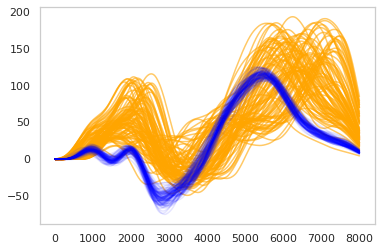

In [47]:
for i in range(100):
    plt.plot(s_x_prior[i], color='orange', alpha=0.6)
    
for i in range(100):
    plt.plot(s_x[i], color='blue', alpha=0.1)

In [ ]:
s_x_torch = torch.stack(([s_x[i] for i in range(len(s_x))]))
s_x_prior_torch = torch.stack(([s_x_prior[i] for i in range(len(s_x_prior))]))


mean = torch.mean(s_x_torch, 0)
std = torch.std(s_x_torch, 0)

mean_prior = torch.mean(s_x_prior_torch, 0)
std_prior = torch.std(s_x_prior_torch, 0)

lower = mean - 1.96 * std


upper = mean + 1.96 * std


lower_prior = mean_prior - 1.96 * std_prior


upper_prior = mean_prior + 1.96 * std_prior



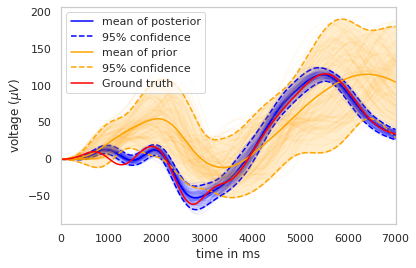

In [49]:
import seaborn as sns

sns.set() 

sns.set_style("whitegrid", {'axes.grid' : False})
#sns.set_style('ticks')

fig1, ax = plt.subplots(1, 1)
#ax.set_title("Comparing signal")

    
plt.plot(mean, color ='blue', label='mean of posterior')

for s in s_x:
    plt.plot(s, alpha=0.05, color='blue')
    #plt.ylim(-30,30)
    plt.xlim(0, 7000)

plt.plot(lower, color='blue', linestyle='dashed', label='95% confidence')
plt.plot(upper, color='blue', linestyle='dashed')
plt.fill_between(x= torch.arange(len(mean_prior)), y1=lower, y2=upper, color='blue', alpha=0.1)
plt.xlim(0, 7000)


plt.plot(mean_prior, color ='orange', label='mean of prior')


for x_w in s_x_prior:
    plt.plot(x_w, alpha=0.05, color='orange')

plt.plot(lower_prior, color='orange', linestyle='dashed', label='95% confidence')
plt.plot(upper_prior, color='orange', linestyle='dashed')
plt.fill_between(x= torch.arange(len(mean_prior)), y1=lower_prior, y2=upper_prior, color='orange', alpha=0.2)
plt.xlim(0, 7000)

plt.xlabel('time in ms')
#plt.ylabel('voltage ()')

fig1.gca().set_ylabel(r'voltage ($\mu V$)')
    
plt.plot(obs_real[0], label='Ground truth', color='red')



plt.legend()

## Correlation matrices

In [24]:
corr_matrix_marginal = np.corrcoef(posterior_samples.T)
fig, ax = plt.subplots(1,1, figsize=(4, 4))
im = plt.imshow(corr_matrix_marginal, clim=[-1, 1], cmap='PiYG')
_ = fig.colorbar(im)

NameError: name 'posterior_samples' is not defined

In [ ]:
condition = posterior.sample((1,))

_ = conditional_pairplot(
    density=posterior,
    condition=condition,
    limits=torch.tensor([[-2., 2.]]*3),
    figsize=(5,5)
)

## Evaluation of features

In [28]:
import matplotlib.cm as cm
import re
from mpl_toolkits.axes_grid1 import make_axes_locatable
from torch import Tensor
from typing import Tuple, List, Optional, Dict
from matplotlib.pyplot import Axes
from matplotlib.figure import Figure
from matplotlib.colors import LogNorm


In [68]:
t = obs_real_stat

t

tensor([[ 1.9490e+03,  2.7060e+03,  5.9300e+03,  2.1558e+01, -4.0164e+01,
          1.9919e+02,  1.5108e+01,  6.7586e+01,  1.9520e+02,  3.2594e+01,
          7.0213e+03,  1.2655e+01,  2.1028e+04, -1.1747e+04,  1.6931e+04,
         -2.2304e+04,  3.4816e+05,  0.0000e+00,  4.7747e+01,  7.9176e+00]],
       dtype=torch.float64)

In [74]:
# t.shape

t1 = torch.cat((t[:,:1], t[:,1+1:]), axis = 1)
print(t1)
t1.shape

tensor([[ 1.9490e+03,  5.9300e+03,  2.1558e+01, -4.0164e+01,  1.9919e+02,
          1.5108e+01,  6.7586e+01,  1.9520e+02,  3.2594e+01,  7.0213e+03,
          1.2655e+01,  2.1028e+04, -1.1747e+04,  1.6931e+04, -2.2304e+04,
          3.4816e+05,  0.0000e+00,  4.7747e+01,  7.9176e+00]],
       dtype=torch.float64)


torch.Size([1, 19])

In [54]:
posterior.set_default_x(obs_real_stat)

DirectPosterior(
               method_family=snpe,
               net=<a Flow, see `.net` for details>,
               prior=BoxUniform(Uniform(low: torch.Size([17]), high: torch.Size([17])), 1),
               x_shape=torch.Size([1, 20]))
               

In [55]:
thetas = posterior.sample((10000,))
thetas.shape

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

torch.Size([10000, 17])

In [79]:

for i in range(20):
    x = calculate_summary_stats_temporal(x_without)
    #leaving one summary statistic out
    x_c = torch.cat((x[:,:i], x[:,i+1:]), axis = 1)
    print(x_c.shape)
    print('t shape', t.shape)
    print(torch.cat((t[:i], t[i+1:]), axis = 0).shape)
    inf = SNPE(prior=prior, density_estimator = 'nsf')
    inf = inf.append_simulations(thetas, x_c)
    density_estimator = inf.train()
    posterior1 = inf.build_posterior(density_estimator)
    globals()['samples_%s' % i] = posterior1.sample((num_samples,), x=torch.cat((t[:,:i], t[:,i+1:]), axis = 1))


torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([0, 20])
Neural network successfully converged after 32 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 34 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 32 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 30 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 29 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 31 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 32 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 28 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 31 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 32 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 31 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 31 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 28 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 35 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 31 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 31 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 34 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 32 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 32 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 31 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

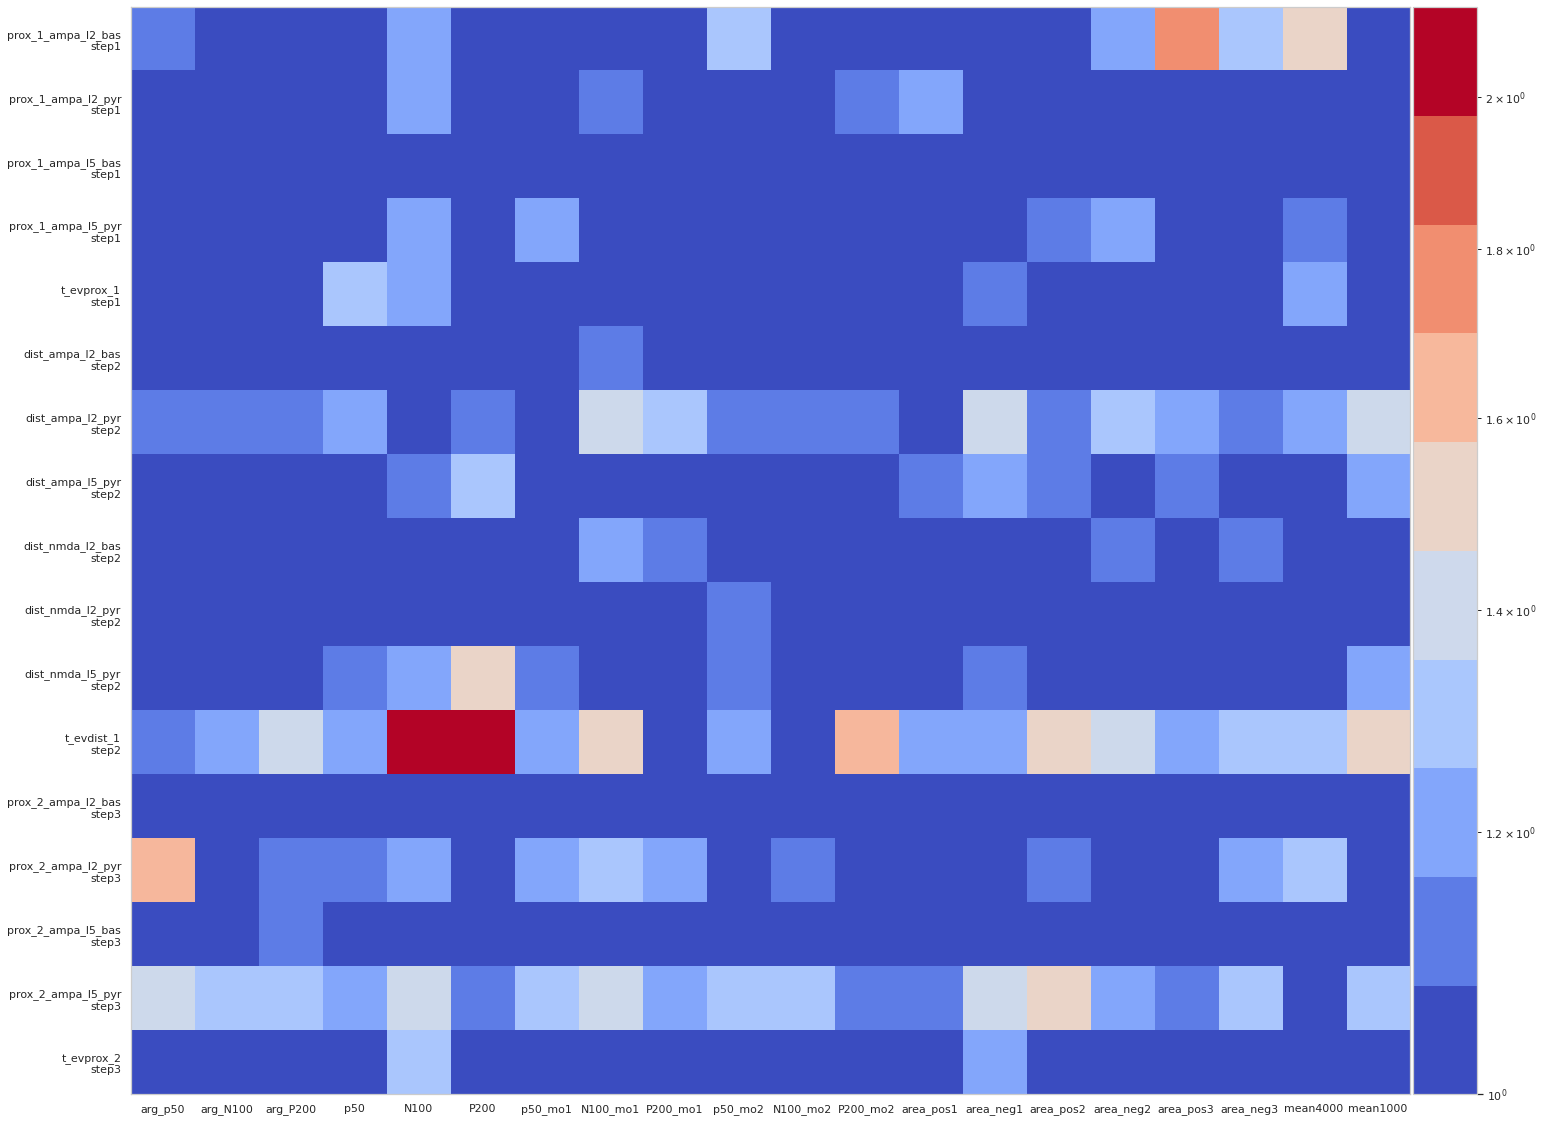

In [106]:
sum_stats_names =                 [
                    'arg_p50',
                    'arg_N100',
                    'arg_P200',
                    'p50',
                    'N100',
                    'P200',
                    'p50_mo1',
                    'N100_mo1',
                    'P200_mo1',
                    'p50_mo2',
                    'N100_mo2',
                    'P200_mo2',
                    'area_pos1',
                    'area_neg1',
                    'area_pos2',
                    'area_neg2',
                    'area_pos3',
                    'area_neg3',
                    'mean4000',
                    'mean1000'
                ]

sample_list = []
for i in range(20):
    sample_list.append(globals()['samples_%s' % i] )

    
plt.figure(figsize = (25,20))
im = plot_varchanges(sample_list, samples, xticklabels=sum_stats_names, yticklabels= parameter_names, plot_label='', batchsize=0)
plt.show(im)

In [120]:
sample_batch = []
batch_size = 5

for i in range(batch_size):

    sample_list = []
    
    for i in range(20):
        

        x = calculate_summary_stats_temporal(x_without)
        #leaving one summary statistic out
        x_c = torch.cat((x[:,:i], x[:,i+1:]), axis = 1)
        print(x_c.shape)
        print('t shape', t.shape)
        print(torch.cat((t[:i], t[i+1:]), axis = 0).shape)
        inf = SNPE(prior=prior, density_estimator = 'nsf')
        inf = inf.append_simulations(thetas, x_c)
        density_estimator = inf.train()
        posterior1 = inf.build_posterior(density_estimator)
        globals()['samples_%s' % i] = posterior1.sample((num_samples,), x=torch.cat((t[:,:i], t[:,i+1:]), axis = 1))
        
        sample_list.append(globals()['samples_%s' % i] )
        
    sample_batch.append(sample_list)

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([0, 20])
Neural network successfully converged after 32 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 33 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 31 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 33 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 36 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 32 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 31 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 32 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 34 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 32 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 34 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 31 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 32 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 31 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 31 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 33 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 31 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 33 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 31 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 31 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([0, 20])
Neural network successfully converged after 34 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 37 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 31 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 35 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 29 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 32 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 34 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 33 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 32 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 33 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 35 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 30 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 31 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 32 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 28 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 30 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 30 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 32 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 33 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 32 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([0, 20])
Neural network successfully converged after 34 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 32 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 29 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 32 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 31 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 31 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 35 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 28 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 32 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 33 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 33 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 32 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 32 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 34 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 29 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 32 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 31 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 36 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 33 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 29 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([0, 20])
Neural network successfully converged after 33 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 30 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 32 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 33 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 31 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 31 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 32 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 33 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 29 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 30 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 31 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 31 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 30 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 32 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 34 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 34 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 30 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 33 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 33 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 31 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([0, 20])
Neural network successfully converged after 33 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 30 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 34 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 30 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 29 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 37 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 32 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 33 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 33 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 31 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 34 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 29 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 33 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 31 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 32 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])
Neural network successfully converged after 37 epochs.


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([10000, 19])
t shape torch.Size([1, 20])
torch.Size([1, 20])


KeyboardInterrupt: 

In [119]:
sample_batch

[]

/home/ubuntu/miniconda3/envs/sbi_env/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  


Text(0, 0.5, 'voltage ($\\mu V$)')

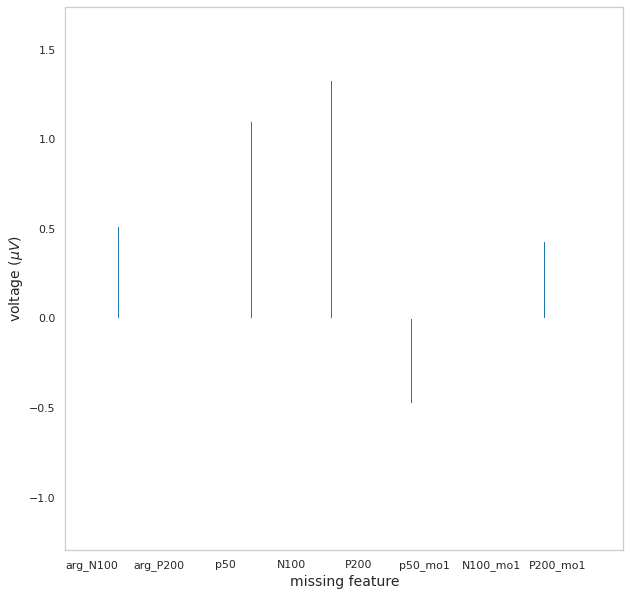

In [117]:
fig, axes = plt.subplots(1, 1, figsize=(10, 10), sharex=True)


plot_KLs(sample_list,
        samples,
        idx=0,
        batchsize=0,
         kind='bar',
        agg_with='mean'
    )


axes.set_xlabel("missing feature", size=14)
axes.set_xticklabels(sum_stats_names)
ax.tick_params(axis="both", which="major", labelsize=12)
ylabel = ax.get_ylabel()
axes.set_ylabel(ylabel, size=14)


In [77]:
#s_x_prior_stat = calculate_summary_stats_temporal(s_x_prior)
#s_x_stat = calculate_summary_stats_temporal(s_x)
 
    
s_x_prior_stat = prior.sample((10000,))

s_x_stat = posterior.sample((10000,))

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

In [85]:
s_x_prior_stat[0][24]

tensor(141.5685)

In [ ]:
import matplotlib.gridspec as gridspec

sum_stats_names =                  [
                    'arg_p50',
                    'arg_N100',
                    'arg_P200',
                    'p50',
                    'N100',
                    'P200',
                    'p50_moment1',
                    'N100_moment1',
                    'P200_moment1',
                    'p50_moment2',
                    'N100_moment2',
                    'P200_moment2',
                    'area_pos1',
                    'area_neg1',
                    'area_pos2',
                    'area_neg2',
                    'area_pos3',
                    'area_neg3',
                    'mean4000',
                    'mean1000'
                ]

fig = plt.figure(figsize=(10,5*s_x_prior_stat.shape[1]), tight_layout=True)

gs = gridspec.GridSpec(nrows=len(sum_stats_names), ncols=1)



#fig.suptitle('Summary stats histogram from posterior predictions.', y=0.2, fontsize=16)


for i in range(len(sum_stats_names)):

    globals()['ax%s' % i] = fig.add_subplot(gs[i])

    globals()['sum_stats%s' % i] = []
    globals()['x%s' % i] = []

    for j in range(s_x_prior_stat.shape[0]):
        globals()['sum_stats%s' % i].append(s_x_stat[j][i])
        globals()['x%s' % i].append(s_x_prior_stat[j][i])

    sum_stat = globals()['sum_stats%s' % i]
    
    
    ##define bins such that we get an equal number of bins at the end
    
    binsteps = np.abs(max(sum_stat)-min(sum_stat))*0.03 + 0.001
    
   
    binrange = np.arange(min(sum_stat), max(sum_stat) + binsteps, binsteps)
    
   
    
    globals()['ax%s' % i].hist(globals()['sum_stats%s' % i],  density=True, bins = binrange,  facecolor='g', alpha=0.75, histtype='barstacked', label='from posterior')
    globals()['ax%s' % i].hist(globals()['x%s' % i],  density=True, bins = binrange,   facecolor='b', alpha=0.5, histtype='barstacked', label='from proposal/prior')
    
  
    globals()['ax%s' % i].set_title('Histogram of summary stat "{}" '.format(sum_stats_names[i]), pad=20)
    #ax0.set(ylim=(-500, 7000))

    globals()['ax%s' % i].axvline(obs_real_stat[0][i].detach().numpy(), color='red', label='ground truth')
    globals()['ax%s' % i].legend(loc='upper right')